<a href="https://colab.research.google.com/github/carinunez/ControlNet/blob/main/ControlNet_try2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ControlNet

Integrantes:
- xx
- xx
- xx
-xx

Arquitectura neuronal utilizada para agregar controles/restricciones especiales a los modelos de difusión de texto a imágenes preentrenados. En este caso, la arquitectura se aplico a Stable Diffusion, creando una copia entrenable de la UNet en el encoder que se une al modelo original utilizando zero-convolutions.


Escoger qué condiciones se probarán-> pose, profundidad,


In [ ]:
import torch
import torch.nn as nn
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import (StableDiffusionPipeline, DPMScheduler, UNet2DConditionModel)
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

In [ ]:
model_id = "stabilityai/stable-diffusion-1-5"
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_f

# 1. Carga de los datos

Se considerarán máscaras generadas a partir de poses de yoga

In [ ]:
class ControlDataset(Dataset):
    def __init__(self, image_dir, control_dir, prompts_file, size=512):
        self.image_paths = sorted(list(Path(image_dir).glob("*.png")))
        self.control_paths = sorted(list(Path(control_dir).glob("*.png")))
        self.prompts = [line.strip() for line in open(prompts_file)]
        self.image_trans = T.Compose([
            T.Resize((size, size)),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self.image_trans(Image.open(self.image_paths[idx]).convert("RGB"))
        ctrl = self.image_trans(Image.open(self.control_paths[idx]).convert("RGB"))
        prompt = self.prompts[idx]
        return img, ctrl, prompt


Se agrega un acelerador para hacer una prueba

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator(
    mixed_precision="fp16",  # o bf16
    log_with="tensorboard",  # o wandb
    project_dir="./logs")

optimizer = torch.optim.AdamW(
                  filter(lambda p: p.requires_grad, model.parameters()),
                  lr=lr)

# usado para un aprendizaje más suave
lr_scheduler = torch.optim.lr_schedular.CosineAnnealingLR(optimizer,T_max=1000)

model, optimizer, dataloader, lr_scheduler = accelerator.prepare(model, optimizer,
                                                                 dataloader, lr_scheduler)


# 2. Tokenizador

Importamos el tokenizador de Stable Diffusion para evitar problemas/inconsistencias con el tamaño de los embeddings del texto c/r a la unet

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder='tokenizer')
text_enoder = CLIPTextModel.from_pretrained(model_id, subfolder='tokenizer')

def get_text_embedding(prompt):
  inputs = tokenizer(prompt, padding='max_length', trunctation=True,
                     max_length=77, return_tensors='pt')

  with torch.no_grad():
    return text_encoder(**inputs.to('cuda')).last_hidden_state

# 2. Bloques de ControlNet

El bloque de ControlNet toma:
- x: imagen ruidosa
- t: paso de difusión
- encoder_hidden_states: embeddings del texto
- control_im: imagen utilizada para condicionar

Se generan activaciones residuales de control_im con las zeroConv2d, luego inyecto estas activaciones a los bloques originales de Stable Diffusion
Finalmente, se entrena manteniendo congelada la capa original de UNet

In [ ]:
# Forma de inyectar la condicion a StableDifussion
class zeroConv2d(nn.Conv2d):
    def __init__(self, in_c, out_c, kernel_size=1, stride=1, padding=0):
        super().__init__(in_c, out_c, kernel_size, stride, padding)
        nn.init.zeros_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

In [1]:
class ControlNet2(nn.Module):
  def __init__(self, unet:UNet2DConditionModel):
    super().__init__():
    # .eval para congelar los pesos i.e no se entrenan
    self.unet = unet.eval()

    # copia de Stable Diffusion para entrenar
    copy = unet.config()
    self.cond_proj = nn.ModuleList(
        zeroConv2d(copy.in_channels, out_c, kernel_size=3, padding=1)
        # aseguro que la copia tenga la misma cantidad de canales que cada
        # cada bloque de DOWNSAMPLING
        # Con esto puedo sumar directamente las activaciones a la salida en c/bloque
        for out_c in copy.block_out_channels
    )

    # proyeccion bloque central/intermedio de la UNet -> BottleNeck
    self.mid = zeroConv2d(copy.in_cahnnels, copy.block_out_channels[-1], kernel_size=3, padding=1)

  def foward(self, x, timesteps, encoder_hidden_states, control_im):
    # Activaciones de control
    cond_activ = [] # se guardan para usarlos como residual en los down_blocks

    for proj in self.cond_proj:
      cond = proj(control_im)
      cond_activ.append(control_im)

    mid_activ = self.mid(control_im)

    # se guardan los residuos para entregarselos al decoder mediante skip-connections
    down_activ = []
    h=x
    for block, cond_res in zip(self.unet.down_blocks, cond_activ):
      h = block(h, timesteps, encoder_hidden_states)
      h = h + cond_res

    h = self.unet.mid_block(h, timesteps, encoder_hidden_states)
    h = h + mid_activ

    for block, skip in zip(self.unet.down_blocks, reversed(down_activ)):
      h = block(h, timesteps, encoder_hidden_states=skip)

    return self.unet.out(h)



SyntaxError: invalid syntax (ipython-input-1-1395767824.py, line 3)

# 4. Entrenamiento

In [ ]:
# scheduler
noise_sch = DDPMDcheduler(num_train_timesteps=1000)

In [ ]:
def train_CN(model, dataloader, optimizer, lr_scheduler,
             epochs=10, lr=1e-4, save_each=3
             device='cuda'):
  model.to(device)

  for epoch in range(epochs):
    for i (img, ctrl_img, prompt) in enumerate(dataloader):
      img = img.to(device)
      ctrl_img = ctrl_img.to(device)
      text_emb = get_text_embedding(prompt)

      # inicializo el ruido
      noise = torch.rand_like(img)
      steps = torch.randoint(0, 1000, (img.shape[0],), device='cuda').long()
      img_w_noise = noise_scheduler.add_noise(img, noise, timesteps)

      # foward
      pred = model(img_w_noise, steps, text_emb, control_im)

      # loss
      loss = F.mse_loss(pred, noise)

      accelerator.backward(loss)
      optimizer.step()
      lr_schedular.step()
      optimizer.zero_grad()

      if (i+1) %10 == 0:
        print(f'Epoca: {epoch}/epochs Step {step} Loss: {loss.item():.4f}')

      # Checkpoints
      if epoch % save_each == 0:
        accelerator.save_model(model, f"./checkpoints/epoch_{epoch}")


In [ ]:
# Congelo la UNet
for param in model.unet.parameters():
  param.requires_grad = False

# Other

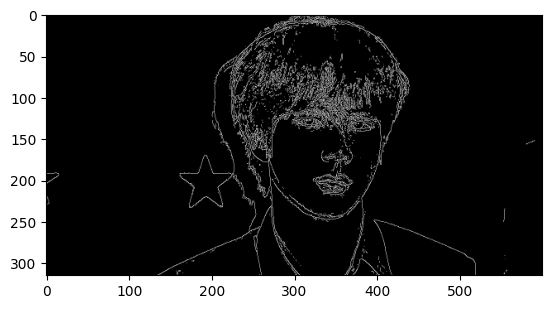

In [ ]:
import cv2
import matplotlib.pyplot as plt

edge = cv2.Canny(cv2.imread('Jin-BTS.png'),80, 95)  # condición
scaling_factor = 0.5
new_width = int(edge.shape[1] * scaling_factor)
new_height = int(edge.shape[0] * scaling_factor)

resized_image = cv2.resize(edge, (new_width, new_height))
gray_img = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
plt.imshow(gray_img)
